# Nicholas Tam Final Visualization

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- What are the numbers and proportions of planted trees, by species, genus, or family?
- Which planted species exist in many different locations within each neighbourhood?
- How do trees that have been planted directly compare in terms of diameter to those that have grown naturally?
- What is the distribution of ages for specific tree species?

## Task Analysis
- Compute: Compute the average percentage differences in `DIAMETER` between planted and non-planted trees, and the ages by the number of days between `DATE_PLANTED` and March 5 2025.
- Filter: Filter out `SPECIES_NAME` such that there are plenty of both planted and non-planted trees.
- Characterize distribution: Find the distribution of ages for planted tree `SPECIES_NAME`.
- Sort: Rank `SPECIES_NAME` for appearing in the greatest number of `NEIGHBOURHOOD_NAME` and having large proportions of each corresponding`ON_STREET` containing them.
- Retrieve value: Retrieve the number of trees that have been planted, separated by `SPECIES_NAME`. 

In [1]:
# !conda install -y geopandas

In [2]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image
import geopandas as gpd
import json

In [3]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
viz_folder = '../../images/ntam_viz/'

# Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

## Processed Data
- Upon loading `public_trees_cleaned.csv`, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.
- `public_trees_planted` is created to filter for species with existing planted trees.

In [4]:
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-03-12,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-11-08,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,2010-10-20,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-12-10,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [5]:
planted_species = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull(), 'SPECIES_NAME'].unique()
public_trees_planted = public_trees_cleaned[public_trees_cleaned['SPECIES_NAME'].isin(planted_species)]

## Visualization 3: How do trees that have been planted directly compare in terms of diameter to those that have grown naturally?

In [6]:
# Select diameter range in histogram
brush_hist = alt.selection_interval(encodings=['x'], name="brushHist")  

# Dropdown family
list_genus = public_trees_planted['GENUS_NAME'].unique().tolist()
dropdown_genus = alt.binding_select(options=[None] + list_genus, name='Genus: ', labels = ['All'] + list_genus)
selection_genus = alt.selection_point(fields=['GENUS_NAME'], bind=dropdown_genus)
predicate_genus = (selection_genus | (alt.datum.GENUS_NAME == None))

# For differences
height_dict = {
    '10-20':15, '20-30':25, '30-40':35, '40-50':45, '50-60':55, '60-70':65, '70-80':75, '80-90':85, '>90':100
}
public_trees_planted['HEIGHT_MEANS'] = public_trees_planted['HEIGHT_RANGE'].astype(str).map(height_dict)

# Calculate the percentage change for each species grouped by whether they are planted or not
species_diffs = public_trees_planted.groupby('SPECIES_NAME').agg(
    GENUS_NAME=('GENUS_NAME', 'first'),
    Diameter_Plant=('DIAMETER', lambda x: x[public_trees_planted['DATE_PLANTED'].notna()].mean()), 
    Diameter_Not_Plant=('DIAMETER', lambda x: x[public_trees_planted['DATE_PLANTED'].isna()].mean()),
    Height_Plant=('HEIGHT_MEANS', lambda x: x[public_trees_planted['DATE_PLANTED'].notna()].mean()), 
    Height_Not_Plant=('HEIGHT_MEANS', lambda x: x[public_trees_planted['DATE_PLANTED'].isna()].mean())
).reset_index()

species_diffs['Percent_Diff_D'] = ((species_diffs['Diameter_Plant'] - species_diffs['Diameter_Not_Plant']) / species_diffs['Diameter_Not_Plant']) * 100
species_diffs['Percent_Diff_H'] = ((species_diffs['Height_Plant'] - species_diffs['Height_Not_Plant']) / species_diffs['Height_Not_Plant']) * 100

hist_base = (
    alt.Chart(species_diffs)
    .mark_bar()
    .encode(
        alt.X('Percent_Diff_H:Q', title="Percentage Change in Height (%)", bin=alt.BinParams(maxbins=20)),
        alt.Y('count():Q'),
        # color=alt.condition(brush_hist, alt.value("#1f77b4"), alt.value("lightgray")),
        # opacity=alt.condition(brush_hist, alt.value(0.9), alt.value(0.2)),
    )
    .add_params(selection_genus, brush_hist)  # Allow selection on histogram
    .transform_filter(predicate_genus) 
    .properties(
        title="Tree Height by Planted Status",
    )
)

# For selection in histogram
hist_diam = alt.layer(
    hist_base.add_params(brush_hist).encode(color=alt.value('lightgrey')),
    hist_base.transform_filter(brush_hist)
)

points = (
    alt.Chart(species_diffs).mark_point(filled=True, size=100).transform_calculate(
        Diff_Category="datum.Percent_Diff_D >= 0 ? 'Positive' : 'Negative'"  # Categorizing increases vs. decreases
    ).encode(
        alt.X('SPECIES_NAME:N', title="Species", sort='-y'),
        alt.Y('Percent_Diff_D:Q', title="Percentage Change in Diameter (%)"),
        alt.Color(
            'Diff_Category:N', 
            scale=alt.Scale(domain=['Positive', 'Negative'], range=['#005AB5', '#DC3220']),  # Blue for increase, Red for decrease
            title="Diameter Change"
        ),
        # opacity=alt.condition(brush_hist, alt.value(0.8), alt.value(0.2)),
        tooltip=[
            alt.Tooltip("SPECIES_NAME:N", title="Species"),
            alt.Tooltip("GENUS_NAME:N", title="Genus"),
            alt.Tooltip("Percent_Diff_D:Q", title="Change in Diameter (%)"),
            alt.Tooltip("Percent_Diff_H:Q", title="Change in Average Height (%)"),
        ]
    )
    .add_params(selection_genus)  # Allow selection on scatter plot
    .transform_filter(brush_hist & predicate_genus)  
    .properties(
        title="Tree Diameter Change by Species",
    )
)


/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_80256/3794890708.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  public_trees_planted['HEIGHT_MEANS'] = public_trees_planted['HEIGHT_RANGE'].astype(str).map(height_dict)


/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


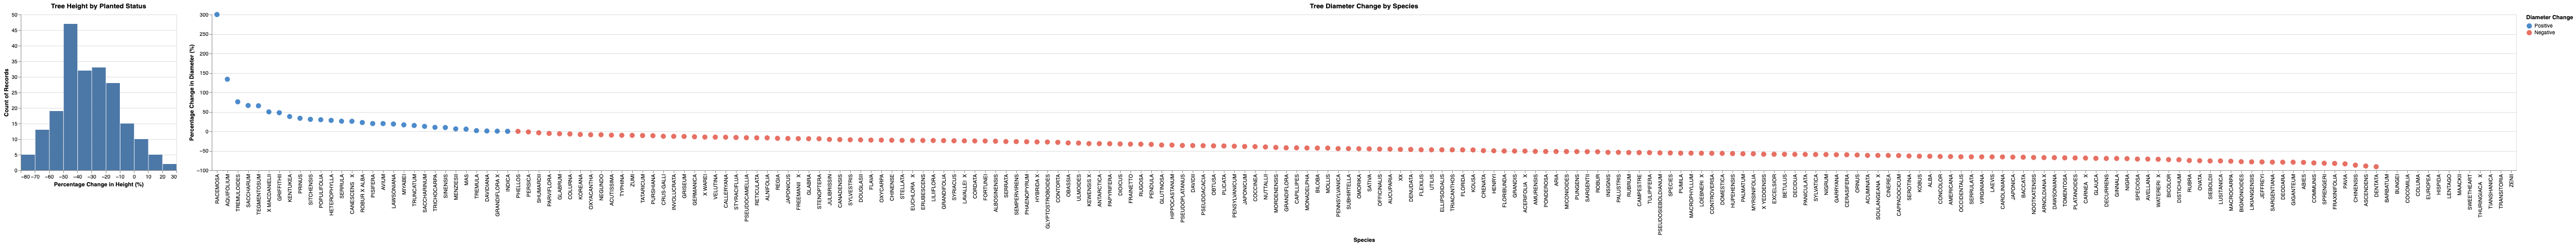

In [7]:
# Combine Histogram and Scatter Plot Side by Side
viz3 = hist_diam | points
viz3